## This file has been modified based on new understandings and methodologies since the original implementation (2 years later)

### Create a Combined Database with Mean Age and Variance by Region Maternal Mortality, Mean and Variance of Adolescent Age Maternal Mortality by Region, GDP by Region, and Population by Region in Mexico.
- This requires the combination of res_dataset (with each Region mean and variance for total and adolescent maternal mortality), metro_by_region (with Metropolitan Areas organized by Region), and mexico_gdp (with GDP values organized by Metropolitan Areas). 

In [1]:
# Import the relevant python libraries for the analysis
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl


# Statistics
import statistics
import scipy.stats as stats
import random
import math
import re
%matplotlib inline

In [2]:
# Load and test Metro by Region dataset and set the index if applicable
metro_by_region = pd.read_excel('../data/metro_area_by_state.xlsx').dropna().reset_index(drop=True)
metro_by_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             74 non-null     object 
 1   Status           74 non-null     object 
 2   State(s)         74 non-null     object 
 3   Population 2010  74 non-null     float64
 4   Population 2015  74 non-null     float64
dtypes: float64(2), object(3)
memory usage: 3.0+ KB


/Users/emily-work/miniconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Step 1: Explore metro_by_region Dataset and Create Clean Sub-Dataframes for Analysis

In [3]:
metro_by_region.head()

,Name,Status,State(s),Population 2010,Population 2015
0,Acapulco,Metropolitan Area,Guerrero,863431.0,886975.0
1,Acayucan,Metropolitan Area,Veracruz de Ignacio de la Llave,112996.0,120340.0
2,Aguascalientes,Metropolitan Area,Aguascalientes,932369.0,1044049.0
3,Campeche,Metropolitan Area,Campeche,259005.0,283025.0
4,Cancún,Metropolitan Area,Quintana Roo,677379.0,763121.0


In [4]:
# Organize dataset by State in alphabetical order
metro_by_region = metro_by_region.sort_values(by=['State(s)'],ascending=True)
metro_by_region.head()

,Name,Status,State(s),Population 2010,Population 2015
2,Aguascalientes,Metropolitan Area,Aguascalientes,932369.0,1044049.0
62,Tijuana,Metropolitan Area,Baja California,1751430.0,1840710.0
18,Ensenada,Metropolitan Area,Baja California,466814.0,486639.0
32,Mexicali,Metropolitan Area,Baja California,936826.0,988417.0
26,La Paz,Metropolitan Area,Baja California Sur,251871.0,272711.0


### Step 2: Merging 3 Dataframes
- Part 1: Match *metro_by_region[State(s]* dataset with *res_dataset* dataset by the 'Providence' columns
- Part 2: Match *metro_by_region['Name']* dataset with *res_dataset* dataset by the 'Metropolitan' columns
- Part 3: Merge *metro_by_region* with *mexico_gdp*
- Part 4: Merge combined *metro_by_region*/*mexico_gdp* with *res_dataset*

### Part 1: Prepare Data for merging *metro_by_region['State(s)']* with *dates['Residence Name']*

#### Assess States/Provinces format in *res_dataset['Region']*

In [5]:
# Open res_dataset as a global variable that can be uploaded to other Jupyter Notebooks
%store -r res_dataset
res_dataset.head()

,Region,μ Age Maternal Mortality,Region (n),μ Age Variance,Equal or Above μ Age in Mexico,Region Mode Education Level,Education Definition,Most Common Region Local Community Size,Local Community Definition,Received Medical Assist
1,Aguascalientes,28.36,127.0,55.16,True,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,0.842105
2,Baja California,27.15,361.0,46.31,False,5.0,SECUNDARIA COMPLETA,16.0,1000000 a 1499999 habitantes,0.844575
3,Baja California Sur,27.56,66.0,55.37,False,6.0,BACHILLERATO O PREPARATORIA COMPLETA,13.0,100000 a 249999 habitantes,0.841270
4,Campeche,26.87,126.0,44.29,False,5.0,SECUNDARIA COMPLETA,13.0,100000 a 249999 habitantes,0.859504
5,Chiapas,28.02,310.0,45.02,False,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,0.877133


In [6]:
print('In res_dataset[Region], there are '+ str(len(np.unique(res_dataset['Region']))) + ' States in Mexico.')
list(np.unique(res_dataset['Region']))

In res_dataset[Region], there are 32 States in Mexico.


['Aguascalientes',
 'Baja California',
 'Baja California Sur',
 'Campeche',
 'Chiapas',
 'Chihuahua',
 'Coahuila de Zaragoza',
 'Colima',
 'Distrito Federal',
 'Durango',
 'Guanajuato',
 'Guerrero',
 'Hidalgo',
 'Jalisco',
 'Michoacán de Ocampo',
 'Morelos',
 'México',
 'Nayarit',
 'Nuevo León',
 'Oaxaca',
 'Puebla',
 'Querétaro Arteaga',
 'Quintana Roo',
 'San Luis Potosí',
 'Sinaloa',
 'Sonora',
 'Tabasco',
 'Tamaulipas',
 'Tlaxcala',
 'Veracruz de Ignacio de la Llave',
 'Yucatán',
 'Zacatecas']

#### Assess States/Provinces format in *metro_by_region['State(s)']*

In [7]:
# Assess the number of Mexico States in dataset
print('The Number of Mexican States in this Dataset is: ',len(metro_by_region['State(s)'].unique()))
list(metro_by_region['State(s)'].unique())

The Number of Mexican States in this Dataset is:  37


['Aguascalientes',
 'Baja California',
 'Baja California Sur',
 'Campeche',
 'Chiapas',
 'Chihuahua',
 'Ciudad de México / Hidalgo / México',
 'Coahuila de Zaragoza',
 'Coahuila de Zaragoza / Durango',
 'Colima',
 'Durango',
 'Guanajuato',
 'Guanajuato / Michoacán de Ocampo',
 'Guerrero',
 'Hidalgo',
 'Jalisco',
 'Jalisco / Nayarit',
 'Michoacán de Ocampo',
 'Morelos',
 'México',
 'Nayarit',
 'Nuevo León',
 'Oaxaca',
 'Puebla',
 'Puebla / Tlaxcala',
 'Querétaro / Guanajuato',
 'Quintana Roo',
 'San Luis Potosí',
 'Sinaloa',
 'Sonora',
 'Tabasco',
 'Tamaulipas',
 'Tamaulipas / Veracruz de Ignacio de la Llave',
 'Tlaxcala',
 'Veracruz de Ignacio de la Llave',
 'Yucatán',
 'Zacatecas']

#### Observations:
As stated when originally cleaning the *res_dataset* in average_age_maternal_mortality Jupyter Notebook, there are 31 states and 1 federal entity in Mexico. Therefore, the length of the metro_by_regions['State(s)'] column is too long at 37 entries. When looking over the list of regions within the dataset, it becomes apparent that there are duplicate entries of States within Mexico, and need to be combined together. Namely:
- 'Coahuila de Zaragoza' = 'Coahuila de Zaragoza' + 'Coahuila de Zaragoza / Durango'
- 'Guanajuato' =  'Guanajuato'+ 'Guanajuato / Michoacán de Ocampo'
- 'Jalisco' =  'Jalisco'+ 'Jalisco / Nayarit'
- 'Puebla' = 'Puebla' + 'Puebla / Tlaxcala'

#### Fix State Names in metro_by_region['States'] dataset

In [8]:
metro_by_region.head()

,Name,Status,State(s),Population 2010,Population 2015
2,Aguascalientes,Metropolitan Area,Aguascalientes,932369.0,1044049.0
62,Tijuana,Metropolitan Area,Baja California,1751430.0,1840710.0
18,Ensenada,Metropolitan Area,Baja California,466814.0,486639.0
32,Mexicali,Metropolitan Area,Baja California,936826.0,988417.0
26,La Paz,Metropolitan Area,Baja California Sur,251871.0,272711.0


In [9]:
# Replace the duplicate 5 Mexican State names with name matching the dates dataset 

#Coahuila de Zaragoza
metro_by_region = metro_by_region.replace('Coahuila de Zaragoza / Durango', 'Coahuila de Zaragoza')

#Guanajuato
metro_by_region = metro_by_region.replace('Guanajuato / Michoacán de Ocampo','Guanajuato')

#Jalisco
metro_by_region = metro_by_region.replace('Jalisco / Nayarit', 'Jalisco')

#Puebla
metro_by_region = metro_by_region.replace('Puebla / Tlaxcala', 'Puebla')

#Tamaulipas
metro_by_region = metro_by_region.replace('Tamaulipas / Veracruz de Ignacio de la Llave', 'Tamaulipas')

In [10]:
# Assess the resulting number of Mexico States in dataset
print('The New Number of Mexican States in this Dataset is: ',len(metro_by_region['State(s)'].unique()))
list(metro_by_region['State(s)'].unique())

The New Number of Mexican States in this Dataset is:  32


['Aguascalientes',
 'Baja California',
 'Baja California Sur',
 'Campeche',
 'Chiapas',
 'Chihuahua',
 'Ciudad de México / Hidalgo / México',
 'Coahuila de Zaragoza',
 'Colima',
 'Durango',
 'Guanajuato',
 'Guerrero',
 'Hidalgo',
 'Jalisco',
 'Michoacán de Ocampo',
 'Morelos',
 'México',
 'Nayarit',
 'Nuevo León',
 'Oaxaca',
 'Puebla',
 'Querétaro / Guanajuato',
 'Quintana Roo',
 'San Luis Potosí',
 'Sinaloa',
 'Sonora',
 'Tabasco',
 'Tamaulipas',
 'Tlaxcala',
 'Veracruz de Ignacio de la Llave',
 'Yucatán',
 'Zacatecas']

**Further Comments**: There are now the correct number of Mexican States in the metro_by_region dataset. Next, in order to smoothly merge *res_datatset* and the combined *metro_by_region*/*mexico_gdp* datastets, there must be at least one shared column name. Therefore, since *metro_by_region* and *res_dataset* share the same column purpose for State names, *res_dataset['Region']* will be renamed to *dates['State']* in order to match *metro_by_region*. Note: Additional modification to *res_dataset* will be applied as needed after the merging of *metro_by_region* and *mexico_gdp*.

In [11]:
res_dataset.head()

,Region,μ Age Maternal Mortality,Region (n),μ Age Variance,Equal or Above μ Age in Mexico,Region Mode Education Level,Education Definition,Most Common Region Local Community Size,Local Community Definition,Received Medical Assist
1,Aguascalientes,28.36,127.0,55.16,True,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,0.842105
2,Baja California,27.15,361.0,46.31,False,5.0,SECUNDARIA COMPLETA,16.0,1000000 a 1499999 habitantes,0.844575
3,Baja California Sur,27.56,66.0,55.37,False,6.0,BACHILLERATO O PREPARATORIA COMPLETA,13.0,100000 a 249999 habitantes,0.841270
4,Campeche,26.87,126.0,44.29,False,5.0,SECUNDARIA COMPLETA,13.0,100000 a 249999 habitantes,0.859504
5,Chiapas,28.02,310.0,45.02,False,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,0.877133


In [12]:
res_dataset.columns

Index(['Region', 'μ Age Maternal Mortality', 'Region (n)', 'μ Age Variance',
       'Equal or Above μ Age in Mexico', 'Region Mode Education Level',
       'Education Definition', 'Most Common Region Local Community Size',
       'Local Community Definition', 'Received Medical Assist'],
      dtype='object')

In [13]:
# In res_dataset, rename 'Region' column to 'State' in order to match metro_by_region
res_dataset.columns = ['State', 'μ Age Maternal Mortality', 'Region (n)', 'μ Age Variance',
       'Equal or Above μ Age in Mexico', 'Region Mode Education Level',
       'Education Definition', 'Most Common Region Local Community Size',
       'Local Community Definition', 'Received Medical Assist']
res_dataset.head()          

,State,μ Age Maternal Mortality,Region (n),μ Age Variance,Equal or Above μ Age in Mexico,Region Mode Education Level,Education Definition,Most Common Region Local Community Size,Local Community Definition,Received Medical Assist
1,Aguascalientes,28.36,127.0,55.16,True,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,0.842105
2,Baja California,27.15,361.0,46.31,False,5.0,SECUNDARIA COMPLETA,16.0,1000000 a 1499999 habitantes,0.844575
3,Baja California Sur,27.56,66.0,55.37,False,6.0,BACHILLERATO O PREPARATORIA COMPLETA,13.0,100000 a 249999 habitantes,0.841270
4,Campeche,26.87,126.0,44.29,False,5.0,SECUNDARIA COMPLETA,13.0,100000 a 249999 habitantes,0.859504
5,Chiapas,28.02,310.0,45.02,False,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,0.877133


#### Assess Metropolitan Areas format in *metro_by_region['Name']* dataset

In [14]:
# Assess the number of Mexico Metro Areas in dataset
print('The Number of Mexican Metropolitan Areas in this Dataset is: ',len(metro_by_region['Name'].unique()))
metro_areas_subdf = metro_by_region['Name'].sort_values()
list(metro_areas_subdf.unique())

The Number of Mexican Metropolitan Areas in this Dataset is:  74


['Acapulco',
 'Acayucan',
 'Aguascalientes',
 'Campeche',
 'Cancún',
 'Celaya',
 'Chetumal',
 'Chihuahua',
 'Chilpancingo',
 'Ciudad Victoria',
 'Coatzacoalcos',
 'Colima - Villa de Álvarez',
 'Cuautla',
 'Cuernavaca',
 'Culiacán',
 'Córdoba',
 'Delicias',
 'Durango',
 'Ensenada',
 'Guadalajara',
 'Guanajuato',
 'Guaymas',
 'Hermosillo',
 'Hidalgo del Parral',
 'Juárez',
 'La Laguna\xa0(Comarca Lagunera, Torreón - Gómez Palacio)',
 'La Paz',
 'La Piedad - Pénjamo',
 'León',
 'Matamoros',
 'Mazatlán',
 'Mexicali',
 'Minatitlán',
 'Monclova - Frontera',
 'Monterrey',
 'Morelia',
 'Moroleón - Uriangato',
 'Mérida',
 'Nogales',
 'Nuevo Laredo',
 'Oaxaca',
 'Ocotlán',
 'Orizaba',
 'Pachuca',
 'Piedras Negras',
 'Poza Rica',
 'Puebla - Tlaxcala',
 'Puerto Vallarta',
 'Querétaro',
 'Reynosa',
 'Ríoverde',
 'Saltillo',
 'San Francisco del Rincón',
 'San Luis Potosí',
 'Tampico',
 'Tapachula',
 'Tecomán',
 'Tehuacán',
 'Tehuantepec\xa0(- Salina Cruz)',
 'Tepic',
 'Teziutlán',
 'Tianguistenco',


#### Observations:
Some of the Metropolitan Area names in *metro_by_region['Name']* need to be cleaned to match *mexico_gdp['Metro Areas']* dataset. Namely:
- 'Acapulco' = 'Acapulco de Juarez' 
- 'Chilpancingo' = 'Chilpancingo de los Bravo'
- 'Colima - Villa de Álvarez' = 'Colima'
-  Culiacán = 'Culiacan'
- 'Zacatecas - Guadalupe' = 'Guadalupe'
- 'Juárez' = 'Juarez'
- 'León' = 'Leon'
- 'Mazatlán' = 'Mazatlan'
- 'Valle de México\xa0[Greater Mexico City]' = 'Mexico City'
- 'Minatitlán' = 'Minatitlan'
- 'Monclova - Frontera' = 'Monclova'
- 'Oaxaca' = 'Oaxaca de Juarez'
- 'Pachuca' = 'Pachuca de Soto'
- 'Poza Rica' = 'Poza Rica de Hidalgo'
- 'Puebla - Tlaxcala' = 'Puebla'
- 'Querétaro' = 'Queretaro' 
- 'San Luis Potosí' = 'San Luis Potosi'
- 'Tehuacán' = 'Tehuacan'
- 'Tlaxcala - Apizaco' = 'Tlaxcala'
- 'La Laguna\xa0(Comarca Lagunera, Torreón - Gómez Palacio)' = 'Torreon'
- 'Tulancingo' = 'Tulancingo de Bravo'
- 'Tuxtla Gutiérrez' = 'Tuxtla Gutierrez'

#### Fix Metropolitan Names in metro_by_region['Name'] dataset
- NOTE: The values not found in the mexico_gdp dataset will be skipped.

In [15]:
# Replace the metropolitan region names with the matching name in the GDP dataset

#Acapulco de Juarez
metro_by_region = metro_by_region.replace('Acapulco', 'Acapulco de Juarez')

#Chilpancingo de los Bravo
metro_by_region = metro_by_region.replace('Chilpancingo', 'Chilpancingo de los Bravo')

#Colima
metro_by_region = metro_by_region.replace('Colima - Villa de Álvarez', 'Colima')

#Culiacan
metro_by_region = metro_by_region.replace('Culiacán', 'Culiacan')

#Guadalupe
metro_by_region = metro_by_region.replace('Zacatecas - Guadalupe', 'Guadalupe')

#Juarez
metro_by_region = metro_by_region.replace('Juárez' , 'Juarez')

#Leon
metro_by_region = metro_by_region.replace('León' , 'Leon')

#Mazatlan
metro_by_region = metro_by_region.replace('Mazatlán' , 'Mazatlan')

#Mexico City
metro_by_region = metro_by_region.replace('Valle de México\xa0[Greater Mexico City]', 'Mexico City')

#Minatitlan
metro_by_region = metro_by_region.replace('Minatitlán' , 'Minatitlan')

#Monclova
metro_by_region = metro_by_region.replace('Monclova - Frontera', 'Monclova')

#Oaxaca de Juarez
metro_by_region = metro_by_region.replace('Oaxaca' , 'Oaxaca de Juarez')

#Pachuca de Soto
metro_by_region = metro_by_region.replace('Pachuca' , 'Pachuca de Soto')

#Poza Rica de Hidalgo
metro_by_region = metro_by_region.replace('Poza Rica' , 'Poza Rica de Hidalgo')

#Puebla
metro_by_region = metro_by_region.replace('Puebla - Tlaxcala', 'Puebla')

#Queretaro
metro_by_region = metro_by_region.replace('Querétaro' , 'Queretaro')

#San Luis Potosi
metro_by_region = metro_by_region.replace('San Luis Potosí' , 'San Luis Potosi')

#Tehuacan
metro_by_region = metro_by_region.replace('Tehuacán' , 'Tehuacan')

#Tlaxcala
metro_by_region = metro_by_region.replace('Tlaxcala - Apizaco', 'Tlaxcala')

#Torren
metro_by_region = metro_by_region.replace('La Laguna\xa0(Comarca Lagunera, Torreón - Gómez Palacio)', 'Torreon')
                                          
#Tulancingo de Bravo
metro_by_region = metro_by_region.replace('Tulancingo' , 'Tulancingo de Bravo')
                                          
#Tuxtla Gutierrez
metro_by_region = metro_by_region.replace('Tuxtla Gutiérrez' , 'Tuxtla Gutierrez')

In [16]:
# Verify results
metro_areas_subdf_2 = metro_by_region['Name'].sort_values()
list(metro_areas_subdf_2.unique())

['Acapulco de Juarez',
 'Acayucan',
 'Aguascalientes',
 'Campeche',
 'Cancún',
 'Celaya',
 'Chetumal',
 'Chihuahua',
 'Chilpancingo de los Bravo',
 'Ciudad Victoria',
 'Coatzacoalcos',
 'Colima',
 'Cuautla',
 'Cuernavaca',
 'Culiacan',
 'Córdoba',
 'Delicias',
 'Durango',
 'Ensenada',
 'Guadalajara',
 'Guadalupe',
 'Guanajuato',
 'Guaymas',
 'Hermosillo',
 'Hidalgo del Parral',
 'Juarez',
 'La Paz',
 'La Piedad - Pénjamo',
 'Leon',
 'Matamoros',
 'Mazatlan',
 'Mexicali',
 'Mexico City',
 'Minatitlan',
 'Monclova',
 'Monterrey',
 'Morelia',
 'Moroleón - Uriangato',
 'Mérida',
 'Nogales',
 'Nuevo Laredo',
 'Oaxaca de Juarez',
 'Ocotlán',
 'Orizaba',
 'Pachuca de Soto',
 'Piedras Negras',
 'Poza Rica de Hidalgo',
 'Puebla',
 'Puerto Vallarta',
 'Queretaro',
 'Reynosa',
 'Ríoverde',
 'Saltillo',
 'San Francisco del Rincón',
 'San Luis Potosi',
 'Tampico',
 'Tapachula',
 'Tecomán',
 'Tehuacan',
 'Tehuantepec\xa0(- Salina Cruz)',
 'Tepic',
 'Teziutlán',
 'Tianguistenco',
 'Tijuana',
 'Tlaxca

In [17]:
metro_by_region.head()

,Name,Status,State(s),Population 2010,Population 2015
2,Aguascalientes,Metropolitan Area,Aguascalientes,932369.0,1044049.0
62,Tijuana,Metropolitan Area,Baja California,1751430.0,1840710.0
18,Ensenada,Metropolitan Area,Baja California,466814.0,486639.0
32,Mexicali,Metropolitan Area,Baja California,936826.0,988417.0
26,La Paz,Metropolitan Area,Baja California Sur,251871.0,272711.0


#### For Analysis of Population in average_age_maternal_mortality, make sub-population dataset

In [18]:
# Combine the Population values for each Mexican State
state_pop = metro_by_region.groupby(['State(s)']).sum().reset_index()
state_pop

,State(s),Population 2010,Population 2015
0,Aguascalientes,932369.0,1044049.0
1,Baja California,3155070.0,3315766.0
2,Baja California Sur,251871.0,272711.0
3,Campeche,259005.0,283025.0
4,Chiapas,1058712.0,1162592.0
5,Chihuahua,2478246.0,2616912.0
6,Ciudad de México / Hidalgo / México,20116842.0,20892724.0
7,Coahuila de Zaragoza,2614817.0,2823877.0
8,Colima,475661.0,512182.0
9,Durango,582267.0,654876.0


In [19]:
len(state_pop)

32

In [20]:
# Store state_pop dataset as a global variable that can be uploaded to other Jupyter Notebooks
%store state_pop

Stored 'state_pop' (DataFrame)


#### Add a State Population columns to metro_by_region
- Create variables for total population by State

In [21]:
# Create empty dictionary variables for state population by year for metro_by_region
#2015
state_population_2015 = {}

In [22]:
# Test code to create function
row = state_pop[state_pop['State(s)'] == 'Campeche']
int(row['Population 2010'].values)

259005

In [23]:
# Add a total state population value for each metro area within a state
for state in state_pop['State(s)']:
    
    # Iterate over state_pop dataset
    for m_state in metro_by_region['State(s)']:
        
        if state == m_state: 
            
            #store pop values of state_pop in metro_by_region
            row = metro_by_region[metro_by_region['State(s)'] == state]
            
            #2015
            p2015 = int(row['Population 2015'].sum())
            state_population_2015[state] = p2015

In [24]:
# Test output
print(len(state_population_2015))
state_population_2015

32


{'Aguascalientes': 1044049,
 'Baja California': 3315766,
 'Baja California Sur': 272711,
 'Campeche': 283025,
 'Chiapas': 1162592,
 'Chihuahua': 2616912,
 'Ciudad de México / Hidalgo / México': 20892724,
 'Coahuila de Zaragoza': 2823877,
 'Colima': 512182,
 'Durango': 654876,
 'Guanajuato': 3250817,
 'Guerrero': 1211397,
 'Hidalgo': 1038974,
 'Jalisco': 5489431,
 'Michoacán de Ocampo': 1177912,
 'Morelos': 1458806,
 'México': 2373347,
 'Nayarit': 471026,
 'Nuevo León': 4689601,
 'Oaxaca de Juarez': 851404,
 'Puebla': 3418377,
 'Querétaro / Guanajuato': 1323640,
 'Quintana Roo': 987201,
 'San Luis Potosi': 1299383,
 'Sinaloa': 1407812,
 'Sonora': 1332448,
 'Tabasco': 823213,
 'Tamaulipas': 2955770,
 'Tlaxcala': 540273,
 'Veracruz de Ignacio de la Llave': 3884243,
 'Yucatán': 1143041,
 'Zacatecas': 375628}

In [25]:
metro_state_pop2015 = []

for state in metro_by_region['State(s)']:
    
    for state15 in state_population_2015:
        
        if state == state15:
            
            #2015
            pop2015 = state_population_2015[state]
            metro_state_pop2015.append(pop2015)

In [26]:
# Test output
print(len(metro_state_pop2015))
#metro_state_pop2010

74


In [27]:
# Convert the state pop lists to a Series and add as new column to metro_by_region

#2015
metro_by_region['State Population 2015'] = metro_state_pop2015
metro_by_region.head()

,Name,Status,State(s),Population 2010,Population 2015,State Population 2015
2,Aguascalientes,Metropolitan Area,Aguascalientes,932369.0,1044049.0,1044049
62,Tijuana,Metropolitan Area,Baja California,1751430.0,1840710.0,3315766
18,Ensenada,Metropolitan Area,Baja California,466814.0,486639.0,3315766
32,Mexicali,Metropolitan Area,Baja California,936826.0,988417.0,3315766
26,La Paz,Metropolitan Area,Baja California Sur,251871.0,272711.0,272711


In [28]:
# Remove metro_by_region['Population 2010', 'Population 2015'] columns as they are no longer needed
metro_by_region = metro_by_region.drop(columns=['Status','Population 2010','Population 2015'])
metro_by_region.head()

,Name,State(s),State Population 2015
2,Aguascalientes,Aguascalientes,1044049
62,Tijuana,Baja California,3315766
18,Ensenada,Baja California,3315766
32,Mexicali,Baja California,3315766
26,La Paz,Baja California Sur,272711


In [29]:
# Rename 'Name' column to 'Metro Areas' in order to match mexico_gdp
metro_by_region.columns = ['Metro Areas', 'State', 'State Population 2015']
metro_by_region.head()

,Metro Areas,State,State Population 2015
2,Aguascalientes,Aguascalientes,1044049
62,Tijuana,Baja California,3315766
18,Ensenada,Baja California,3315766
32,Mexicali,Baja California,3315766
26,La Paz,Baja California Sur,272711


Merge *metro_by_region* with *res_dataset*
- Since *res_dataset* and *metro_by_region* have different lengths, the merging of the two datasets will most likely require an iteration over the rows of *res_dataset*

In [30]:
len(res_dataset)

32

In [31]:
res_dataset.head()

,State,μ Age Maternal Mortality,Region (n),μ Age Variance,Equal or Above μ Age in Mexico,Region Mode Education Level,Education Definition,Most Common Region Local Community Size,Local Community Definition,Received Medical Assist
1,Aguascalientes,28.36,127.0,55.16,True,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,0.842105
2,Baja California,27.15,361.0,46.31,False,5.0,SECUNDARIA COMPLETA,16.0,1000000 a 1499999 habitantes,0.844575
3,Baja California Sur,27.56,66.0,55.37,False,6.0,BACHILLERATO O PREPARATORIA COMPLETA,13.0,100000 a 249999 habitantes,0.841270
4,Campeche,26.87,126.0,44.29,False,5.0,SECUNDARIA COMPLETA,13.0,100000 a 249999 habitantes,0.859504
5,Chiapas,28.02,310.0,45.02,False,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,0.877133


#### Reorder metro_by_region by State

In [32]:
# Reindex dates by State
metro_by_region = metro_by_region.sort_values(by=['State'],ascending=True).reset_index(drop=True)
metro_by_region.head()

,Metro Areas,State,State Population 2015
0,Aguascalientes,Aguascalientes,1044049
1,Tijuana,Baja California,3315766
2,Ensenada,Baja California,3315766
3,Mexicali,Baja California,3315766
4,La Paz,Baja California Sur,272711


#### Remove States in *metro_by_region* that are not in *res_dataset*

In [33]:
condition_3 = metro_by_region['State'].isin(res_dataset['State']) == True
metro_by_region['Drop if False'] = condition_3

# Remove all rows where metro_by_region['Drop if False'] == False
metro_by_region = metro_by_region[metro_by_region['Drop if False'] == True]
len(metro_by_region)
metro_by_region.head()

,Metro Areas,State,State Population 2015,Drop if False
0,Aguascalientes,Aguascalientes,1044049,True
1,Tijuana,Baja California,3315766,True
2,Ensenada,Baja California,3315766,True
3,Mexicali,Baja California,3315766,True
4,La Paz,Baja California Sur,272711,True


In [34]:
# Remove metro_by_region['Drop if False'] column
metro_by_region = metro_by_region.drop(columns=['Drop if False'])
metro_by_region.head()

,Metro Areas,State,State Population 2015
0,Aguascalientes,Aguascalientes,1044049
1,Tijuana,Baja California,3315766
2,Ensenada,Baja California,3315766
3,Mexicali,Baja California,3315766
4,La Paz,Baja California Sur,272711


In [35]:
metro_by_region.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 0 to 73
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Metro Areas            68 non-null     object
 1   State                  68 non-null     object
 2   State Population 2015  68 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.1+ KB


In [36]:
# Remove metro_gdp_merge['Metro Areas'] columns as they are no longer needed
metro_by_region = metro_by_region.drop(columns=['Metro Areas'])
metro_by_region.head()

,State,State Population 2015
0,Aguascalientes,1044049
1,Baja California,3315766
2,Baja California,3315766
3,Baja California,3315766
4,Baja California Sur,272711


## Merge metro_by_region with res_dataset

In [37]:
ml_adomaternal_mortality = pd.merge(metro_by_region, res_dataset, on='State').drop_duplicates()
ml_adomaternal_mortality.head()

,State,State Population 2015,μ Age Maternal Mortality,Region (n),μ Age Variance,Equal or Above μ Age in Mexico,Region Mode Education Level,Education Definition,Most Common Region Local Community Size,Local Community Definition,Received Medical Assist
0,Aguascalientes,1044049,28.36,127.0,55.16,True,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,0.842105
1,Baja California,3315766,27.15,361.0,46.31,False,5.0,SECUNDARIA COMPLETA,16.0,1000000 a 1499999 habitantes,0.844575
4,Baja California Sur,272711,27.56,66.0,55.37,False,6.0,BACHILLERATO O PREPARATORIA COMPLETA,13.0,100000 a 249999 habitantes,0.841270
5,Campeche,283025,26.87,126.0,44.29,False,5.0,SECUNDARIA COMPLETA,13.0,100000 a 249999 habitantes,0.859504
6,Chiapas,1162592,28.02,310.0,45.02,False,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,0.877133


In [38]:
ml_adomaternal_mortality.tail()

,State,State Population 2015,μ Age Maternal Mortality,Region (n),μ Age Variance,Equal or Above μ Age in Mexico,Region Mode Education Level,Education Definition,Most Common Region Local Community Size,Local Community Definition,Received Medical Assist
52,Tamaulipas,2955770,28.26,377.0,45.45,True,5.0,SECUNDARIA COMPLETA,14.0,250000 a 499999 habitantes,0.871866
57,Tlaxcala,540273,28.45,178.0,55.16,True,5.0,SECUNDARIA COMPLETA,5.0,5000 a 9999 habitantes,0.822086
58,Veracruz de Ignacio de la Llave,3884243,27.94,1239.0,53.60,False,2.0,PRIMARIA INCOMPLETA,1.0,1 a 999 habitantes,0.874241
66,Yucatán,1143041,27.50,258.0,54.89,False,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,0.814346
67,Zacatecas,375628,27.50,191.0,48.10,False,5.0,SECUNDARIA COMPLETA,1.0,1 a 999 habitantes,0.919075


In [39]:
ml_adomaternal_mortality[['Received Medical Assist', 'Region (n)']].groupby('Received Medical Assist',
                                                 as_index=False).count()

,Received Medical Assist,Region (n)
0,0.814346,1
1,0.822086,1
2,0.826840,1
3,0.836237,1
4,0.841270,1
5,0.842105,1
6,0.844318,1
7,0.844575,1
8,0.845426,1
9,0.846154,1


#### Look over columns and column correlations: Are all columns in metro_gdp_mortality necessary?

In [40]:
# Create a correlation dataframe
feature_corr = ml_adomaternal_mortality.corr()
feature_corr

,State Population 2015,μ Age Maternal Mortality,Region (n),μ Age Variance,Equal or Above μ Age in Mexico,Region Mode Education Level,Most Common Region Local Community Size,Received Medical Assist
State Population 2015,1.000000,0.403396,0.294634,-0.151977,0.346555,-0.210841,0.167483,-0.017571
μ Age Maternal Mortality,0.403396,1.000000,0.328899,0.393087,0.807419,-0.165981,-0.211814,-0.137525
Region (n),0.294634,0.328899,1.000000,0.203397,0.381747,-0.493669,-0.221252,-0.047626
μ Age Variance,-0.151977,0.393087,0.203397,1.000000,0.374289,-0.373848,-0.429609,-0.196659
Equal or Above μ Age in Mexico,0.346555,0.807419,0.381747,0.374289,1.000000,-0.173205,-0.199854,-0.309417
Region Mode Education Level,-0.210841,-0.165981,-0.493669,-0.373848,-0.173205,1.000000,0.624954,0.034934
Most Common Region Local Community Size,0.167483,-0.211814,-0.221252,-0.429609,-0.199854,0.624954,1.000000,-0.107632
Received Medical Assist,-0.017571,-0.137525,-0.047626,-0.196659,-0.309417,0.034934,-0.107632,1.000000


<AxesSubplot:>

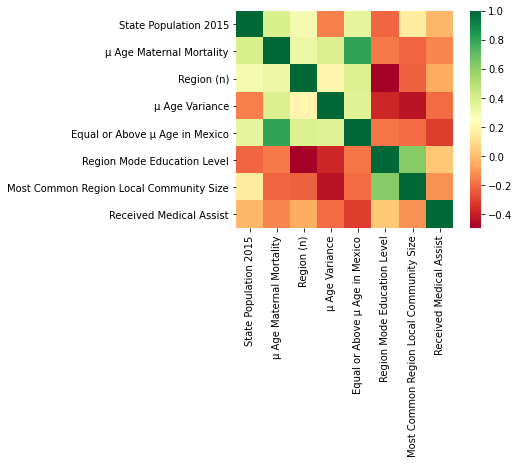

In [41]:
# Plot a correlation heatmap
sns.heatmap(feature_corr, square=True, cmap='RdYlGn')

In [42]:
#Remove columns as that are no longer needed
ml_adomaternal_mortality = ml_adomaternal_mortality.drop(columns=['μ Age Maternal Mortality'])
ml_adomaternal_mortality.head()

,State,State Population 2015,Region (n),μ Age Variance,Equal or Above μ Age in Mexico,Region Mode Education Level,Education Definition,Most Common Region Local Community Size,Local Community Definition,Received Medical Assist
0,Aguascalientes,1044049,127.0,55.16,True,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,0.842105
1,Baja California,3315766,361.0,46.31,False,5.0,SECUNDARIA COMPLETA,16.0,1000000 a 1499999 habitantes,0.844575
4,Baja California Sur,272711,66.0,55.37,False,6.0,BACHILLERATO O PREPARATORIA COMPLETA,13.0,100000 a 249999 habitantes,0.841270
5,Campeche,283025,126.0,44.29,False,5.0,SECUNDARIA COMPLETA,13.0,100000 a 249999 habitantes,0.859504
6,Chiapas,1162592,310.0,45.02,False,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,0.877133


<AxesSubplot:>

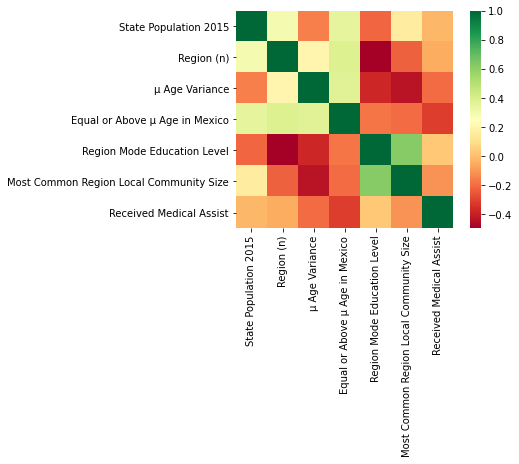

In [43]:
# Plot a correlation heatmap
sns.heatmap(ml_adomaternal_mortality.corr(), square=True, cmap='RdYlGn')

In [44]:
# Store merged metro_gdp_mortality dataset as a global variable
%store ml_adomaternal_mortality

Stored 'ml_adomaternal_mortality' (DataFrame)
